## By Jacob Turner

##### Import FEniCS module

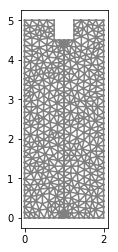

TypeError: q() missing 3 required positional arguments: 'I', 'R', and 'V'

In [3]:
from fenics import *
from mshr import *
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf') 
import numpy as np 
import sympy as sym 

##### Create the mesh on the domain that describes the battery cell. 

# enter battery domain dimensions
battery_height = 4.5
battery_width = 2.0
tab_height = 0.5
tab_width = 0.75

# cathode dimensions
cwidth = 0.00010 # cathode width
cdist = 0.10 # cathode distance from top and bottom of battery cell

# Main Cell Body
originx = originy = 0.0
cornerx = battery_width
cornery = battery_height

# Positive tab domain
pox = 0.0
poy = battery_height
pcx = tab_width
pcy = battery_height + tab_height

# Negative tab domain
nox = battery_width - tab_width
noy = battery_height
ncx = battery_width
ncy = pcy

# define cathode dimensions
cox = battery_width/2 - cwidth/2
coy = cdist
ccx = battery_width/2 + cwidth/2
ccy = battery_height - cdist

# Elements in mesh:
meshsize = 20

cell = Rectangle( dolfin.Point(originx,originy), dolfin.Point(cornerx,cornery))
ptab = Rectangle( dolfin.Point(pox, poy), dolfin.Point(pcx, pcy))
ntab = Rectangle( dolfin.Point(nox, noy), dolfin.Point(ncx, ncy))
cathode = Rectangle( dolfin.Point(cox, coy), dolfin.Point(ccx, ccy))

domain = cell + ptab + ntab - cathode

mesh = generate_mesh(domain, meshsize)
V = FunctionSpace(mesh, 'CG', 1)

plot(mesh)
plt.show()

##### Defining the heat source generation function.

u = Function(V)
# define function that describes the heat generation in the battery 
def q(u, I, R, V) : 
    #I = 2.0 # current of the battery (Amps)
    Vol = 10 # volume of the battery (mm^2)
    #R = 80 # Internal Resistance of the battery (Ohms) [Increases y-intercept]
    #V = - .015 # coefficient voltage variation with temperature in battery cell [Increases Slope]
    return (I/Vol)*(I*R + V*u)
# plotting the function
x = np.linspace(1,300, 1000)
#plt.plot(x, q(x))

rho = Constant(1) #2000
Cp = Constant(1) #900
k = Constant(1) #1.6

##### Define values for the dirichlet boundary conditions of the battery cell. 

gD_top = Constant(35.0) #Expression('x[1]*x[1]', degree = 1) # Constant(100.0) # Dirichlet Boundaeies :top and bottom of battery are exposed to ambient temperature
gD_bottom = Constant(20.0)
gD_left = Constant(30.0)
gD_right = Constant(30.0)
# initial condtions in the battery cell.
u_int = Constant(1.0) #Expression('exp(-a*pow(x[0], 2) - a*pow(x[1], 2))',degree=2, a=1)
#u_int = Expression('exp(-10*(x[0]*x[0] + x[1]*x[1]))', degree = 1) # Constant(1.0) #Expression('sin(x[0] + x[1])', degree = 1)#Constant(1.0) # Initial condition :begin at same temp as outside
u0 = interpolate(u_int, V)

##### Define boundaries of the battery cell. 

# defining parts of the boundaries by creating classes
class tab_top (SubDomain): 
    def inside (self , x , on_boundary): 
        return near( x[1], pcy)
# battery cell main core
class Left (SubDomain):
    def inside (self , x , on_boundary):
        return near(x[0], originx)
class Right (SubDomain):
    def inside (self , x , on_boundary):
        return near(x[0], cornerx)
class Bottom (SubDomain):
    def inside (self , x , on_boundary):
        return near(x[1], originy)
class Top (SubDomain):
    def inside (self , x , on_boundary):
        return near(x[1], cornery)
# create classes for cathode boundaries
class cathode_left (SubDomain):
    def inside (self, x, on_boundary):
        return near(x[0], cox)
class cathode_right (SubDomain):
    def inside (self, x, on_boundary):
        return near(x[0], ccx)
class cathode_top (SubDomain):
    def inside (self, x, on_boundary):
        return near(x[1], coy)
class cathode_bottom (SubDomain):
    def inside (self, x, on_boundary):
        return near(x[1], ccy)

tab = tab_top()
    
# create each instance of the classess created above
left = Left()
right = Right()
top = Top()
bottom = Bottom()

# instantiate classes for the cathode boundaries
cleft = cathode_left()
cright = cathode_right()
ctop = cathode_top()
cbottom = cathode_bottom()

# Initialize mesh function for boundary domains and mark
boundaries = MeshFunction("size_t", mesh , 1) #
boundaries.set_all(0) #

left.mark(boundaries , 1)
top.mark(boundaries , 2)
right.mark(boundaries , 3)
bottom.mark(boundaries , 4)

cleft.mark(boundaries , 5)
ctop.mark(boundaries , 6)
cright.mark(boundaries , 7)
cbottom.mark(boundaries , 8)

tab.mark(boundaries , 9)

ds = Measure("ds", domain = mesh, subdomain_data = boundaries) #

# dont apply these in simulation to use all neumann boundaries [Dirichlet BC Conds.]
bc_bottom = DirichletBC(V, gD_bottom, boundaries, 4)# bottom of the battery cell 
bc_top = DirichletBC(V, gD_top, boundaries, 9) # top of the tab bc
bc_right = DirichletBC(V, gD_right, boundaries, 3)# bottom of the battery cell 
bc_left = DirichletBC(V, gD_left, boundaries, 1) # top of the tab bc
bct = [bc_bottom, bc_top] # store dirichlet in array 

##### Declare values for nuemann boundaries of the battery cell.

# Heat flux from batteries on boundaries
# Neumann for left and right boundary
gN_left = Constant(10.0) 
gN_right = Constant(10.0)
# declare neumann for top and bottom boundaries if necessary.
gN_top = Constant(5.0)
gN_bottom = Constant(5.0)
# cathode boundary values
gN_cleft = q(u, I, R, V) #Constant(10.0) 
gN_cright = q(u, I, R, V) #Constant(10.0)
gN_ctop = q(u, I, R, V) #Constant(10.0)
gN_cbottom = q(u, I, R, V) #Constant(1.0)
# Tab neumann boundaries values
gN_tab = Constant(5.0)

##### Initiate time interval and step to run simulation over. 

#define time interval and step size
num_steps = 1000
T = 10.0
dt = T/num_steps
t = 0

In [1]:
#sensitivity Analysis
sens = ['I', 'R', 'V']

I = 2.0 # current of the battery (Amps)
R = 80 # Internal Resistance of the battery (Ohms) [Increases y-intercept]
V = - .015

for i in sens :
    for i in range(-50, 50, 5) :
        if sens[i] = 'I' :
            I = I + I*(i/100)
            print('I = ', I)
            storeI = []
            storeI.append[I]
        elif sens[i] = 'R' :
            R = R + R*(i/100)
            print('R = ', R)
            storeR = []
            storeR.append[R]
        elif sens[i] = 'V' :
            V = V + V*(i/100)
            print('V = ', V)
            storeV = []
            storeV.append[V]
            
        ##### Create variational problem
        # variational problem
        u = TrialFunction(V)
        v = TestFunction(V)
        f = q(u, I, R, V) 

        up = u0 # store u(t=0) in new var

        F =  k*u*v*dx + rho*Cp*dt*inner(grad(u), grad(v))*dx \
        - (u0 + dt*f)*v*dx - dt*gN_left*v*ds(1) - dt*gN_right*v*ds(3) \
        - dt*gN_top*v*ds(2) - dt*gN_bottom*v*ds(4) - dt*gN_cleft*v*ds(5) \
        - dt*gN_cright*v*ds(7) - dt*gN_ctop*v*ds(6) - dt*gN_cbottom*v*ds(8) \
        - dt*gN_tab*v*ds(9) 

        # create time dependence here?

        a = lhs(F) # left hand side
        L = rhs(F) # right hand side
        A = assemble(a)
        u = Function(V)

        ##### Run the simulation over the previously entered time interval. 

        #vtkfile = File('Battery_paraview/final_simulations/final.pvd') # Store results of simulation here
        t = 0 #initialize time
        # time travel
        for n in range(num_steps) :
            t += dt
            #print("t = ", t)

            b = assemble(L)
            bc_bottom.apply(A,b) # apply bottom dirchlet
            bc_top.apply(A,b) # apply top dirchlet
            bc_left.apply(A,b) # apply left dirchlet
            bc_right.apply(A,b) # apply right dirchlet
            solve(A, u.vector(), b)

            n = FacetNormal(mesh)

            # compute the power transfer through each boundary
            flux = inner(grad(u0), n)*ds(4) #flux through bottom 
            power_bottom = assemble(flux) #integrate flux to get power

            flux = inner(grad(u0), n)*ds(2) #flux through top boundary
            power_top = assemble(flux) #integrate flux to get power

            flux = inner(grad(u0), n)*ds(3) #flux through right boundary
            power_right = assemble(flux) #integrate flux to get power

            flux = inner(grad(u0), n)*ds(1) #flux through left boundary
            power_left = assemble(flux) #integrate flux to get power

            flux = inner(grad(u0), n)*ds(9) #flux through left boundary
            power_tabs = assemble(flux) #integrate flux to get power

            # update
            up.assign(u)
            vtkfile << (u,t) # save

        if sens[i] = 'I' :
            top_I = []
            bott_I = []
            right_I = []
            left_I = []

            top_I.append[power_top]
            bott_I.append[power_bottom]
            right_I.append[power_right]
            left_I.append[power_left]
        elif sens[i] = 'R' :
            top_R = []
            bott_R = []
            right_R = []
            left_R = []

            top_R.append[power_top]
            bott_R.append[power_bottom]
            right_R.append[power_right]
            left_R.append[power_left]
        elif sens[i] = 'V' :
            top_V = []
            bott_V = []
            right_V = []
            left_V = []

            top_V.append[power_top]
            bott_V.append[power_bottom]
            right_V.append[power_right]
            left_V.append[power_left]
        

        """
        %matplotlib inline
        plot(u)
        plt.savefig(fname = "batt_temp_u.jpg", dpi = 500)
        plt.show()

        %matplotlib inline
        #plot(mesh)
        plot(-grad(u))
        plt.savefig(fname = "gradient_u.jpg", dpi = 500)
        plt.show()


        ##### Print heat transfer results through each of the relevent boundaries.

        print("The energy transfer through the bottom boundary is {}".format(power_bottom), "Joules")
        print("The energy transfer through the top boundary is {}".format(power_top), "Joules")
        print("The energy transfer through the right boundary is {}".format(power_right), "Joules")
        print("The energy transfer through the left boundary is {}".format(power_left), "Joules")
        print("The energy transfer through the tabs is {}".format(power_tabs), "Joules")

        """



In [ ]:
# plot stuff
plt.plot(storeI, right_I)
plt.plot(storeV, right_V)
plt.plot(storeR, right_R)
plt.title("Right boundary energy transfer")
plt.ylabel("Energy Transfer (Joules)")
plt.xlabel("% change in parameter")
plt.savefig("sens_right.jpg", dpi = 500)
plt.show()
